# Inverting the Formula for the Ising Coupling Matrix 

## Notes on Network Performance

Currently the parameters $\mu$ and $\Omega$ are taken from a uniform distribution. The output activations will also lie in the (0,1) interval. The expected distance between two values drawn from a uniform [0,1] distribution is $\frac{1}{3}$. Since we have $n^2+n$ parameters for an ion chain of size n, we get that if the network is outputting just a guess that the cost should be approximately $\frac{n^2+n}{6}$.(since we are currently using a quadratic cost function)

For a network with n=3 I have been able to get a cost of just under a quarter of this value for my synthetic data set up to this point.
I am still researching ways to improve hyperparameter selection as well as improved network architecture.

One question I have is to evaluate what is a good cost value for the test set and what is not. And whether or not it is a good physical representation of the system to have the parameters taken from a uniform distribution.

In [1]:
import ionchain
import classes
import pickle
import numpy as np
import network
import network2
% matplotlib inline

## Functions to Model the Physical System
These functions, Lambe_Dicke J_ij1 and J_ij used to make the necessary calculations to model an instance of an ion chain.

In [2]:
def Lamb_Dicke(ic):
    """Computes Lamb-Dicke parameters for a trapped ion chain 
    
    Args:
        ic (Object) - an instance of a trapped ion chain
        
    Returns:
        An nxn matrix where n is the number of ions in the ion chain.
        The i,mth entry of the matrix corresponds to the Lambe-Dicke
        parameter eta[i,m] which sets the scale for the coupling between
        spin i and mode m.
    """
    deltak = 2*1.7699*10**7
    M = 2.8395 * 10**(-25)
    hbar = 1.0546e-34
    n = ic.n
    b_ij = ic.x_eigvecs
    omega_m = ic.x_freqs
    eta = np.empty([n,n])
    for m in range(n):
        for i in range(n):
            eta[i,m] = b_ij[i,m]*deltak*((hbar/(2*M*omega_m[m]))**0.5)
    return eta

In [3]:
def J_ij1(mu, Rabi_freq, ic):
    """Computes spin-spin coupling beteen atoms in a trapped ion
    chain with global beatnote detuning. 
    
    Args:
        mu(float) - global beatnote detuning parameter
        ic (Object) - an instance of a trapped ion chain
        Rabi_freq(An 1Xn vector of floats, where n is number of ions
        in the chain) 
            - containing where the ith entry is the single spin Rabi
            frequency of atom i
        
    Returns:
        An nxn matrix where n is the number of ions in the ion chain.
        The i,jth is the spin-spin coupling beteen atoms i and j in the
        ion chain.
    """
    n = ic.n
    eta = Lamb_Dicke(ic)
    omega_m = ic.x_freqs
    J = np.empty((n,n))
    for i in range(n):
        J[i,i] = 0
        for j in range(i+1,n):
            J[i,j] = Rabi_freq[i]*Rabi_freq[j]* np.sum(eta[i, :] * eta[j, :] * omega_m[:] /(np.full((1,n),mu)**2 - omega_m[:]**2))
    return J

In [4]:
def J_ij(mus, Rabi_freq_matrix, ic):
    n = ic.n
    eta = Lamb_Dicke(ic)
    omega_m = ic.x_freqs
    F = np.empty((n, n, len(mus)))
    for i in range(n):
        for j in range(n):
            for m in range(len(mus)):
                F[i, j, m] = np.sum(eta[i, :] * eta[j, :] * omega_m[:] /
                                    (mus[m]**2 - omega_m[:]**2))
    J = np.empty((n, n))
    for i in range(n):
        J[i, i] = 0
        for j in range(i + 1, n):
            J[i, j] = np.sum(Rabi_freq_matrix[i, :] * Rabi_freq_matrix[j, :] * F[i, j, :])
            J[j, i] = J[i, j]
    return J

## Generating Synthetic Data
The functions test_data and create_data_file are used to generate synthetic data for training, testing, and validation.

To create a synthetic data set one must just modify the code in the cell below the one where these functions are defined.

In [5]:
def test_data(ic, data_size):
    """Generates training, test and validation data for a 
    particular ion chain ic. The function returns 3 tuples corresponding 
    to each data set. Each tuple contains 2 items. The first is the J_ij
    values for the system in vectorized form(by row). If n is the size of
    the ion chain, the second contains a vector whose first n entires
    are the parameters mu and the remaining entires are the vectorized
    form of the Rabi frequency matrix
    
    Arguments:
    ic(Object from IonChain Class)-the ion chain from which to construct
    data from
    data_size(Int)-desired data size"""
    n = ic.n
    np.random.seed(123)
    
    # Generate random values for the Rabi matricies and detunings(the first mu_size values correspond
    #to mu and the rest to the Rabi frequencies.
    # The size of the ion chain will determine the number of output values in the network.
    data = []
    for i in range (0, data_size):
        mu = np.random.uniform(low=0, high=1, size=(n,1))
        Rabi = np.random.uniform(low=0, high=1, size=(n,n))     
    # For each set of parameters y we generate corresponding Ising coupling matrix J which
    # will be our input parameters for the neural network
        J = J_ij(mu, Rabi, ic)
        x = np.reshape(J,(n**2,1))
        y = np.concatenate((mu, np.reshape(Rabi,(n**2,1))), axis=0)
        data.append((x,y))  
    
    # Return the dataset in pairs of x,y for train/test/validation sets.
    return data

def create_data_file(filename, ic, data_size):
    """Creates a pickled file containing synthetic test data.
    Arguments:
    filename(string)-desired filename
    ic(Object from IonChain Class)-the ion chain from which to construct
    data from
    data_size(Int)-desired data size"""
    data = test_data(ic, data_size)
    f = open(filename, 'wb')
    pickle.dump(data, f)
    f.close()
    

In [6]:
ionchain3 = ionchain.IonChain(3,[5,1])
#create_data_file('chain_len3.pickle',ionchain3,100000)

## Training and Validation
The following code is used to define a create a neural network and its architecture, using a modified version of Micheal Nielsons network2.py file, then test a data set on it.


Epoch 0 training complete
Cost on training data: 0.8836191089795746
Cost on evaluation data: 0.8754371667904394
Epoch 1 training complete
Cost on training data: 0.8250746778633739
Cost on evaluation data: 0.8180814253089868
Epoch 2 training complete
Cost on training data: 0.7732488680401428
Cost on evaluation data: 0.7677428582228002
Epoch 3 training complete
Cost on training data: 0.7282743884809495
Cost on evaluation data: 0.7243750880874648
Epoch 4 training complete
Cost on training data: 0.6896787630808562
Cost on evaluation data: 0.6876090083913923
Epoch 5 training complete
Cost on training data: 0.6573179831166331
Cost on evaluation data: 0.6570252946028878
Epoch 6 training complete
Cost on training data: 0.6304916629716729
Cost on evaluation data: 0.6319307225847863
Epoch 7 training complete
Cost on training data: 0.6083907737412552
Cost on evaluation data: 0.6114488902081872
Epoch 8 training complete
Cost on training data: 0.5900604290231215
Cost on evaluation data: 0.594605903

Epoch 73 training complete
Cost on training data: 0.48871114272331084
Cost on evaluation data: 0.502752665173702
Epoch 74 training complete
Cost on training data: 0.48860925580928166
Cost on evaluation data: 0.502653387674384
Epoch 75 training complete
Cost on training data: 0.4884989210525243
Cost on evaluation data: 0.502555312056797
Epoch 76 training complete
Cost on training data: 0.48838685435152657
Cost on evaluation data: 0.5024681970349081
Epoch 77 training complete
Cost on training data: 0.48828131132335717
Cost on evaluation data: 0.5023983096642367
Epoch 78 training complete
Cost on training data: 0.4881798542744493
Cost on evaluation data: 0.5023125058987068
Epoch 79 training complete
Cost on training data: 0.48807823885084556
Cost on evaluation data: 0.5022342767829387
Epoch 80 training complete
Cost on training data: 0.4879825296574005
Cost on evaluation data: 0.50216572535326
Epoch 81 training complete
Cost on training data: 0.48788635868404784
Cost on evaluation data: 0

Epoch 145 training complete
Cost on training data: 0.48302074590896116
Cost on evaluation data: 0.4977436715655379
Epoch 146 training complete
Cost on training data: 0.48294926717646475
Cost on evaluation data: 0.4976682618456991
Epoch 147 training complete
Cost on training data: 0.4828777921501726
Cost on evaluation data: 0.4975921775832612
Epoch 148 training complete
Cost on training data: 0.4828072828611595
Cost on evaluation data: 0.49750864440809067
Epoch 149 training complete
Cost on training data: 0.4827376954270112
Cost on evaluation data: 0.49743165156647917
Epoch 150 training complete
Cost on training data: 0.4826684948041428
Cost on evaluation data: 0.49737879389245326
Epoch 151 training complete
Cost on training data: 0.4825996089005223
Cost on evaluation data: 0.49729304714247324
Epoch 152 training complete
Cost on training data: 0.4825309087952219
Cost on evaluation data: 0.49722298195717735
Epoch 153 training complete
Cost on training data: 0.4824628246428675
Cost on eva

Cost on training data: 0.47834624563089145
Cost on evaluation data: 0.49329112708901385
Epoch 218 training complete
Cost on training data: 0.47828443765741246
Cost on evaluation data: 0.49323207956277343
Epoch 219 training complete
Cost on training data: 0.4782226948620523
Cost on evaluation data: 0.49317321411039905
Epoch 220 training complete
Cost on training data: 0.47816105408289006
Cost on evaluation data: 0.49312598553141496
Epoch 221 training complete
Cost on training data: 0.4780998316235532
Cost on evaluation data: 0.4930768307288703
Epoch 222 training complete
Cost on training data: 0.4780384316890235
Cost on evaluation data: 0.49302106772150656
Epoch 223 training complete
Cost on training data: 0.47797740524276844
Cost on evaluation data: 0.49295782744610667
Epoch 224 training complete
Cost on training data: 0.4779165354162342
Cost on evaluation data: 0.4929026529904026
Epoch 225 training complete
Cost on training data: 0.4778559266344182
Cost on evaluation data: 0.492852988

Epoch 289 training complete
Cost on training data: 0.4743536742999485
Cost on evaluation data: 0.4898385857067579
Epoch 290 training complete
Cost on training data: 0.4743050527745836
Cost on evaluation data: 0.4897897505260615
Epoch 291 training complete
Cost on training data: 0.47425631821223097
Cost on evaluation data: 0.4897434358950351
Epoch 292 training complete
Cost on training data: 0.474207755458338
Cost on evaluation data: 0.4897218069539807
Epoch 293 training complete
Cost on training data: 0.47415931606672274
Cost on evaluation data: 0.489674835593224
Epoch 294 training complete
Cost on training data: 0.4741110578119035
Cost on evaluation data: 0.48962818117374435
Epoch 295 training complete
Cost on training data: 0.47406292762543134
Cost on evaluation data: 0.489575642198536
Epoch 296 training complete
Cost on training data: 0.4740149103910025
Cost on evaluation data: 0.4895461830857708
Epoch 297 training complete
Cost on training data: 0.4739673110627912
Cost on evaluatio

Epoch 361 training complete
Cost on training data: 0.47117321387580374
Cost on evaluation data: 0.48711818423084113
Epoch 362 training complete
Cost on training data: 0.47113245757625216
Cost on evaluation data: 0.48706566160405557
Epoch 363 training complete
Cost on training data: 0.4710921950042737
Cost on evaluation data: 0.4870337349533694
Epoch 364 training complete
Cost on training data: 0.47105201156592297
Cost on evaluation data: 0.48699164209267365
Epoch 365 training complete
Cost on training data: 0.4710122621433306
Cost on evaluation data: 0.48694904803582795
Epoch 366 training complete
Cost on training data: 0.47097259362828253
Cost on evaluation data: 0.4869196791593577
Epoch 367 training complete
Cost on training data: 0.47093332174045865
Cost on evaluation data: 0.48689869046114165
Epoch 368 training complete
Cost on training data: 0.4708940777454468
Cost on evaluation data: 0.4868461579404813
Epoch 369 training complete
Cost on training data: 0.470855306136705
Cost on e

Cost on training data: 0.4686514120540264
Cost on evaluation data: 0.48483587173557613
Epoch 434 training complete
Cost on training data: 0.4686207118550748
Cost on evaluation data: 0.48482325708043655
Epoch 435 training complete
Cost on training data: 0.46859061033963295
Cost on evaluation data: 0.4847677111233075
Epoch 436 training complete
Cost on training data: 0.46856033721612506
Cost on evaluation data: 0.4847376488533103
Epoch 437 training complete
Cost on training data: 0.46853022182114684
Cost on evaluation data: 0.4847232679043091
Epoch 438 training complete
Cost on training data: 0.4685000602261591
Cost on evaluation data: 0.4846908568494784
Epoch 439 training complete
Cost on training data: 0.46847003494768075
Cost on evaluation data: 0.48467265398200476
Epoch 440 training complete
Cost on training data: 0.4684400768748726
Cost on evaluation data: 0.48463961397417027
Epoch 441 training complete
Cost on training data: 0.468410249318686
Cost on evaluation data: 0.484623700806

Cost on training data: 0.46668737675035193
Cost on evaluation data: 0.4830356568058088
Epoch 506 training complete
Cost on training data: 0.46666335303672174
Cost on evaluation data: 0.4830077616842956
Epoch 507 training complete
Cost on training data: 0.4666391745079276
Cost on evaluation data: 0.48299555211221085
Epoch 508 training complete
Cost on training data: 0.4666149619456868
Cost on evaluation data: 0.48297942380281317
Epoch 509 training complete
Cost on training data: 0.46659080471301906
Cost on evaluation data: 0.48294955136525686
Epoch 510 training complete
Cost on training data: 0.4665666036669167
Cost on evaluation data: 0.48293821579500784
Epoch 511 training complete
Cost on training data: 0.46654265447867566
Cost on evaluation data: 0.4829127640513062
Epoch 512 training complete
Cost on training data: 0.46651894974537844
Cost on evaluation data: 0.48288692904897984
Epoch 513 training complete
Cost on training data: 0.46649512568487245
Cost on evaluation data: 0.48287966

Epoch 577 training complete
Cost on training data: 0.4651008388166713
Cost on evaluation data: 0.4815290442915525
Epoch 578 training complete
Cost on training data: 0.46508090726110934
Cost on evaluation data: 0.4815040822533059
Epoch 579 training complete
Cost on training data: 0.46506096845753997
Cost on evaluation data: 0.4814873910802912
Epoch 580 training complete
Cost on training data: 0.46504115801571433
Cost on evaluation data: 0.48148343597096366
Epoch 581 training complete
Cost on training data: 0.46502127926788983
Cost on evaluation data: 0.48146832987787225
Epoch 582 training complete
Cost on training data: 0.46500131698878383
Cost on evaluation data: 0.4814410336904815
Epoch 583 training complete
Cost on training data: 0.4649814077381958
Cost on evaluation data: 0.4814279481188777
Epoch 584 training complete
Cost on training data: 0.46496164134735796
Cost on evaluation data: 0.4814147434924023
Epoch 585 training complete
Cost on training data: 0.4649420904157105
Cost on ev

Epoch 649 training complete
Cost on training data: 0.46370683020861403
Cost on evaluation data: 0.48019398162720034
Epoch 650 training complete
Cost on training data: 0.46368800372626817
Cost on evaluation data: 0.48017706512026254
Epoch 651 training complete
Cost on training data: 0.4636693982214585
Cost on evaluation data: 0.4801466379850958
Epoch 652 training complete
Cost on training data: 0.4636508176663323
Cost on evaluation data: 0.48013206628050153
Epoch 653 training complete
Cost on training data: 0.4636320333267097
Cost on evaluation data: 0.48011372072261804
Epoch 654 training complete
Cost on training data: 0.4636138119643931
Cost on evaluation data: 0.4800904475827685
Epoch 655 training complete
Cost on training data: 0.46359509759583634
Cost on evaluation data: 0.480072801498554
Epoch 656 training complete
Cost on training data: 0.46357660897073855
Cost on evaluation data: 0.4800598128494452
Epoch 657 training complete
Cost on training data: 0.46355780627114757
Cost on ev

Cost on training data: 0.462440146423895
Cost on evaluation data: 0.4790733044290986
Epoch 722 training complete
Cost on training data: 0.46242433512469355
Cost on evaluation data: 0.47904883598683085
Epoch 723 training complete
Cost on training data: 0.46240908243818
Cost on evaluation data: 0.4790338067320384
Epoch 724 training complete
Cost on training data: 0.46239348067540814
Cost on evaluation data: 0.47900672154263413
Epoch 725 training complete
Cost on training data: 0.4623775476657269
Cost on evaluation data: 0.47900002201662145
Epoch 726 training complete
Cost on training data: 0.4623620338269225
Cost on evaluation data: 0.47898068455208137
Epoch 727 training complete
Cost on training data: 0.46234636249662864
Cost on evaluation data: 0.47896045134031584
Epoch 728 training complete
Cost on training data: 0.46233077629802716
Cost on evaluation data: 0.47893030576306134
Epoch 729 training complete
Cost on training data: 0.46231612995528765
Cost on evaluation data: 0.47890703475

Cost on training data: 0.46134808795085924
Cost on evaluation data: 0.47789532289598907
Epoch 794 training complete
Cost on training data: 0.46133339228897946
Cost on evaluation data: 0.4778714957040717
Epoch 795 training complete
Cost on training data: 0.4613188237871884
Cost on evaluation data: 0.4778463227873271
Epoch 796 training complete
Cost on training data: 0.4613043056271356
Cost on evaluation data: 0.47784160705018375
Epoch 797 training complete
Cost on training data: 0.4612892766076077
Cost on evaluation data: 0.47783598332491267
Epoch 798 training complete
Cost on training data: 0.4612745154970863
Cost on evaluation data: 0.47782188059178604
Epoch 799 training complete
Cost on training data: 0.4612598531721323
Cost on evaluation data: 0.4778092553435047
Epoch 800 training complete
Cost on training data: 0.46124534736526923
Cost on evaluation data: 0.47780677364453106
Epoch 801 training complete
Cost on training data: 0.46123094624744654
Cost on evaluation data: 0.4777982786

Epoch 865 training complete
Cost on training data: 0.46027083459358287
Cost on evaluation data: 0.4768863776555935
Epoch 866 training complete
Cost on training data: 0.4602546658131666
Cost on evaluation data: 0.47685907639594644
Epoch 867 training complete
Cost on training data: 0.4602385793085901
Cost on evaluation data: 0.47685475936805516
Epoch 868 training complete
Cost on training data: 0.46022246966826064
Cost on evaluation data: 0.47684308683128485
Epoch 869 training complete
Cost on training data: 0.46020671224571774
Cost on evaluation data: 0.47683229046764997
Epoch 870 training complete
Cost on training data: 0.4601906937211031
Cost on evaluation data: 0.476820211661135
Epoch 871 training complete
Cost on training data: 0.4601751203936392
Cost on evaluation data: 0.4767902466851068
Epoch 872 training complete
Cost on training data: 0.4601589525827728
Cost on evaluation data: 0.4767777607196179
Epoch 873 training complete
Cost on training data: 0.4601427984437393
Cost on eval

Epoch 937 training complete
Cost on training data: 0.45914170772275326
Cost on evaluation data: 0.4757568703097234
Epoch 938 training complete
Cost on training data: 0.4591258856371629
Cost on evaluation data: 0.4757555479415582
Epoch 939 training complete
Cost on training data: 0.45910978988798534
Cost on evaluation data: 0.47574236388769453
Epoch 940 training complete
Cost on training data: 0.459093630272229
Cost on evaluation data: 0.47572712529137445
Epoch 941 training complete
Cost on training data: 0.4590778145392534
Cost on evaluation data: 0.47573107451968055
Epoch 942 training complete
Cost on training data: 0.45906193592326416
Cost on evaluation data: 0.47571494137240466
Epoch 943 training complete
Cost on training data: 0.45904609476678315
Cost on evaluation data: 0.4757116644734828
Epoch 944 training complete
Cost on training data: 0.45903015894119126
Cost on evaluation data: 0.4756991110207816
Epoch 945 training complete
Cost on training data: 0.4590140380700229
Cost on ev

([0.8754371667904394,
  0.8180814253089868,
  0.7677428582228002,
  0.7243750880874648,
  0.6876090083913923,
  0.6570252946028878,
  0.6319307225847863,
  0.6114488902081872,
  0.5946059036904546,
  0.5803464001796651,
  0.5678386050365237,
  0.5566136282894603,
  0.5464337116074947,
  0.5373192266698283,
  0.5294553820050785,
  0.5230025811127615,
  0.5179552585574198,
  0.5142368654735974,
  0.5115938159961009,
  0.509785455554254,
  0.5085907578874322,
  0.5077936297866263,
  0.5072753617201263,
  0.5069300322522913,
  0.5067130601037891,
  0.5065557798529622,
  0.5064357814071825,
  0.5063374292555117,
  0.5062385095788395,
  0.5061512324918584,
  0.5060562527514157,
  0.5059497834432638,
  0.5058682755545117,
  0.5057766636196884,
  0.5056867153163133,
  0.505603375710499,
  0.5055193543026658,
  0.5054271063171273,
  0.5053491843339696,
  0.5052806078051407,
  0.5052005053066975,
  0.5051007723731854,
  0.5050025125453602,
  0.5048834123876375,
  0.5047259815490823,
  0.50460979

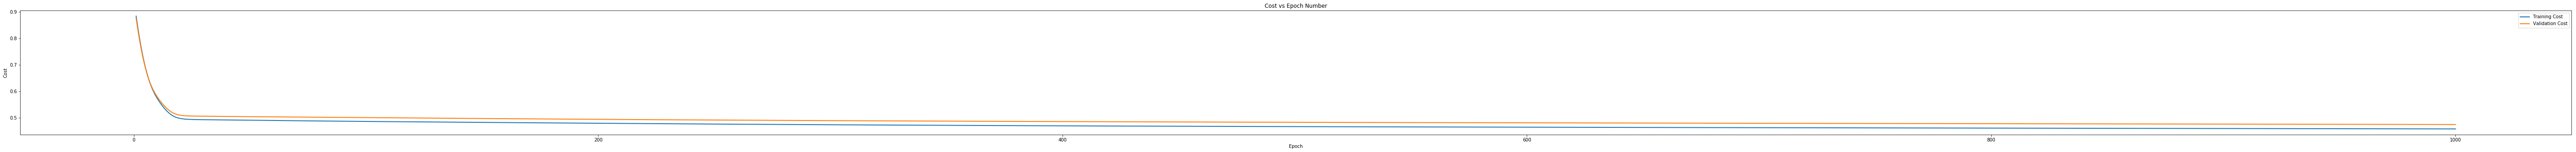

In [7]:
net = network2.Network([9,100,12])
data = pickle.load(open('chain_len3.pickle', "rb"))
# train_data = data[:int(len(data)*0.8)]
#test_data = data[int(len(data)*0.8):]
train_data = data[:1000]
test_data = data[1000:1100]
net.SGD(train_data, 1000, 10, 0.001,lmbda = 0, evaluation_data=test_data,eta_update=0)


## Testing
The following code can be modified and used for testing.

In [11]:
#net.save('Network_with_cost_0.4_for_n=3.txt')

In [13]:
net1 = network2.load('Network_with_cost_0.4_for_n=3.txt')

In [14]:
net1.total_cost_no_reg(data)

0.4621823707924954